# Impactos da proposta eleitoral de distritão nas eleições para deputados federais

No distritão, a eleição para deputados federais seria majoritária, e não proporcional. 
Ou seja: em cada UF, seriam eleitos os $n$ mais votados, onde $n$ é o número de cadeiras disponíveis àquela UF. 
No sistema atual (proporcional), o número de eleitos de um partido é proporcional ao total de votos obtidos por todos os candidatos do partido.

Para verificar o possível impacto do distritão nas eleições para deputados federais, vamos verificar quem seriam os eleitos caso essa fosse a regra eleitoral e comparar com os efetivamente eleitos (dentro do sistema proporcional).

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np

import utils as xu

## Funções

In [2]:
def load_tse_data(ano):
    
    cand     = pd.read_csv('../dados/limpos/consulta_cand_{}_BRASIL.csv'.format(ano), low_memory=False)
    votos    = pd.read_csv('../dados/limpos/total_votos_por_eleicao_e_candidato_{}.csv'.format(ano), low_memory=False)
    receitas = pd.read_csv('../dados/limpos/total_receitas_por_candidato_{}.csv'.format(ano), low_memory=False)
    
    return cand, votos, receitas


def clean_cand(df, cargos):
    
    cols_interest = ['SG_UF', 'DS_CARGO', 'SQ_CANDIDATO', 'NR_CANDIDATO', 'NM_CANDIDATO', 'NM_URNA_CANDIDATO',
           'NR_CPF_CANDIDATO', 'DS_SITUACAO_CANDIDATURA', 'DS_DETALHE_SITUACAO_CAND', 'SG_PARTIDO', 'SQ_COLIGACAO',
           'NM_COLIGACAO', 'DS_COMPOSICAO_COLIGACAO', 'DS_NACIONALIDADE', 'SG_UF_NASCIMENTO',
           'NM_MUNICIPIO_NASCIMENTO', 'DT_NASCIMENTO', 'NR_IDADE_DATA_POSSE', 'NR_TITULO_ELEITORAL_CANDIDATO', 'DS_GENERO',
           'DS_GRAU_INSTRUCAO', 'DS_ESTADO_CIVIL', 'DS_COR_RACA', 'DS_OCUPACAO', 'DS_SIT_TOT_TURNO', 'ST_REELEICAO', 
           'ST_DECLARAR_BENS', 'DS_SITUACAO_CANDIDATO_PLEITO', 'DS_SITUACAO_CANDIDATO_URNA', 'ST_CANDIDATO_INSERIDO_URNA']

    sel = df
    sel = sel.loc[sel['DS_CARGO'].isin(cargos) & (sel['DS_SITUACAO_CANDIDATURA'] == 'APTO'), cols_interest]
    
    return sel


def join_votos_receita(cand, votos, receitas):
    
    df = cand
    df = df.join(votos.set_index('SQ_CANDIDATO')['QT_VOTOS_NOMINAIS'], on='SQ_CANDIDATO', how='left')
    df = df.join(receitas.set_index('sequencial_candidato')['receita_total'], on='SQ_CANDIDATO', how='left')
    
    return df


def load_previously_elected(ano, cargos, key):
    """
    Load candidates TSE data for same-level previous 
    elections (e.g. if, `ano` is 2018, load data from 
    2014) and return a Series whose index are given 
    by column `key` (str) and the values are whether 
    (1) or not (0) the candidate was elected for cargo 
    in `cargos`.
    
    Note:
    - The column `key` must contain integer-conversible 
      entries.
    """
    
    prev_ano = ano - 4
    # Load data:
    df = pd.read_csv('../dados/limpos/consulta_cand_{}_BRASIL.csv'.format(prev_ano), low_memory=False)
    
    # Select desired cargos:
    df = df.loc[df['DS_CARGO'].isin(cargos)]
    # Select good-to-go candidaturas:
    df = df.loc[df['DS_DETALHE_SITUACAO_CAND'].isin(['DEFERIDO', 'DEFERIDO COM RECURSO', 'INDEFERIDO COM RECURSO'])]
    
    # Check whether the candidate was elected or not:
    df['ELEITO_ANTERIOR'] = df['DS_SIT_TOT_TURNO'].isin(['ELEITO POR QP', 'ELEITO POR MÉDIA']).astype(int)
    
    df[key] = df[key].astype(int)
    series = df.set_index(key)['ELEITO_ANTERIOR']
    return series


def join_prev_elected(df, prev_elected, key):
    """
    Join the `prev_elected` Series (containing 
    a boolean int stating whether the candidate 
    was elected or not in a previous election)
    to `df` (DataFrame) on the column `key` (str).
    
    Note:
    - The `prev_elected` index must be the same 
      info as in `df` column `key`.
    """
    
    cols = list(df.columns) + ['ELEITO_ANTERIOR']
    
    # Join:
    df['prev_key'] = df[key].astype(int)
    df = df.join(prev_elected, how='left', on='prev_key')
    # Fill missing values with "not elected":
    df['ELEITO_ANTERIOR'].fillna(0, inplace=True)
    df['ELEITO_ANTERIOR'] = df['ELEITO_ANTERIOR'].astype(int)
    
    return df[cols]


def etl_tse_data(ano, cargos, fill_receita='median', drop_nan_votes=True):
    
    cand, votos, receitas = load_tse_data(ano)
    cand = clean_cand(cand, cargos)
    df = join_votos_receita(cand, votos, receitas)
    
    # Join info about previous election:
    prev_key = 'NR_TITULO_ELEITORAL_CANDIDATO'
    prev_elected = load_previously_elected(ano, cargos, prev_key)
    df = join_prev_elected(df, prev_elected, prev_key)
    
    # Fill missing receita values:
    if fill_receita == 'median':
        df['receita_total'].fillna(df['receita_total'].median(), inplace=True)
    elif fill_receita == 0:
        df['receita_total'].fillna(0, inplace=True)
    
    # Drop candidates with no votes:
    if drop_nan_votes:
        df = df.loc[~df['QT_VOTOS_NOMINAIS'].isnull()]
        df['QT_VOTOS_NOMINAIS'] = df['QT_VOTOS_NOMINAIS'].astype(int)
    
    return df


def load_vagas_data(ano, cargos):
    vagas = pd.read_csv('../dados/brutos/consulta_vagas_{}_BRASIL.csv'.format(ano), sep=';', encoding='latin-1', low_memory=False)
    vagas = vagas.loc[vagas['DS_CARGO'].str.upper().isin(cargos)]
    return vagas

In [3]:
def votes_to_position_in_uf(df, uf, cargo):
    """
    Set a ranking, starting from 1, of the candidates with 
    the highest votes in `uf` (str) and for `cargo` (str).
    
    Return a Series with SQ_CANDIDATO as index and the 
    position in the ranking as values.
    """
    sel = df.loc[(df['SG_UF'] == uf) & (df['DS_CARGO'] == cargo), ['SQ_CANDIDATO', 'QT_VOTOS_NOMINAIS']]
    position = sel.sort_values('QT_VOTOS_NOMINAIS', ascending=False).reset_index(drop=True).reset_index()
    position['index'] = position['index'] + 1
    position.rename({'index':'POSICAO'}, axis=1, inplace=True)
    position_series = position.set_index('SQ_CANDIDATO')['POSICAO']
    
    return position_series

In [4]:
def votes_to_position(df, cargo):
    """
    Create and return a Series with the position 
    of the candidate in a ranking of most voted 
    for `cargo` (str) inside its UF, based on 
    a DataFrame `df` containing the the columns
    SQ_CANDIDATO, DS_CARGO, SG_UF and QT_VOTOS_NOMINAIS.
    """
    uf_list = sorted(df['SG_UF'].unique())
    series  = pd.concat([votes_to_position_in_uf(df, uf, cargo) for uf in uf_list])
    return series

In [5]:
def etl_elected_data_two_systems(ano, cargo):
    """
    Load and process TSE data to return a DataFrame 
    with information about candidatos aptos for 
    `cargo` (str) and year `ano` (int) and whether
    they were elected and whether they would be elected 
    in a 'distritão style' election.
    """
    
    # Load a bunch of TSE DATA, clean it and filter it:
    df = etl_tse_data(ano, [cargo], fill_receita='median', drop_nan_votes=True)
    # Create a column that tells if the candidate was elected or not:
    df['ELEITO_REAL'] = df['DS_SIT_TOT_TURNO'].isin(['ELEITO POR QP', 'ELEITO POR MÉDIA']).astype(int)

    # Load the amount of seats per UF:
    vagas = load_vagas_data(ano, [cargo])

    # Verifica que o número de eleitos é igual ao número de vagas:
    assert (df.loc[df['ELEITO_REAL'] == 1].groupby('SG_UF').size() == vagas.set_index('SG_UF')['QT_VAGAS'].sort_index()).all()

    # Find out position on a most-voted ranking:
    position = votes_to_position(df, cargo)

    # Join position and number of seats to DataFrame:
    cand_position = df.join(position, how='left', on='SQ_CANDIDATO')
    cand_position = cand_position.join(vagas.set_index('SG_UF')['QT_VAGAS'], how='left', on='SG_UF')

    # Create a column that identifies those that would receive votes:
    cand_position['ELEITO_DISTRITAO'] = (cand_position['POSICAO'] <= cand_position['QT_VAGAS']).astype(int)
    
    return cand_position

In [6]:
def locate_rejected_inserted(df):
    """
    Take a DataFrame `df` of candidatos aptos, 
    previously cleaned and filtered, and split 
    into DataFrames `rejected` and `inserted`, 
    that is, those that would be removed from 
    congress if "distritão" was adopted, and 
    those that would enter if "distritão" was
    adopted.
    
    Return:
    rejected : DataFrame
    inserted : DataFrame
    """
    rejected = df.loc[(df['ELEITO_REAL'] == 1) & (df['ELEITO_DISTRITAO'] == 0)]
    inserted = df.loc[(df['ELEITO_REAL'] == 0) & (df['ELEITO_DISTRITAO'] == 1)]
    
    return rejected, inserted


def compute_change_balance(rejected, inserted, category):
    """
    Given two DataFrames `rejected` and `inserted` of 
    candidates that would be removed from and inserted 
    in the congress if the proposed change was adopted, 
    compute the balance for each category listed in the 
    DataFrame's column `category` (str).
    
    Return: DataFrame
    """
    
    # Count how many would exit the congress after proposed change, by category:
    rejected_by_party = rejected[category].value_counts()
    rejected_by_party.name = 'perde_com_distritao'
    
    # Count how many would enter the congress after proposed change, by category:
    inserted_by_party = inserted[category].value_counts()
    inserted_by_party.name = 'ganha_com_distritao'

    # Join enter and exit counts:
    balance_by_party = inserted_by_party.reset_index().merge(rejected_by_party.reset_index(), on='index', how='outer').fillna(0)
    # Set category as index:
    balance_by_party.rename({'index': category}, axis=1, inplace=True)
    balance_by_party.set_index(category, inplace=True)
    # Organize data:
    balance_by_party = balance_by_party.astype(int)
    # Compute enter/exit balance by category:
    balance_by_party['saldo'] = balance_by_party['ganha_com_distritao'] - balance_by_party['perde_com_distritao']

    return balance_by_party.sort_values('saldo', ascending=False)

In [7]:
def bin_receitas(series, receita_min=0, receita_max=2600000, n_bins=10):
    """
    Create a binned version of `series` by assigning labels to the 
    values inside the specififed bins. The labels are the bins' top 
    edges.
    
    Return : Series
    """
    # Define bin edges: 
    edges  = np.linspace(receita_min, receita_max, n_bins + 1).astype(int)
    # Define bin labels:
    labels = ['{:,}'.format(x).replace(',', '.') for x in edges[1:]]
    
    # Bin receita series: 
    faixas = pd.cut(series, edges, labels=labels).astype(str)
    
    return faixas

In [8]:
def plot_balance(df, cat_order=None):
    """
    Given a DataFrame `df` with a column 'saldo' that 
    informs how many deputados would be included/excluded
    by the change in the elections, by class (accodring 
    to `df` index), plot this variation.
    """
    
    if cat_order == None:
        toplot = df['saldo'].sort_values()
    else:
        toplot = df.loc[cat_order, 'saldo']
    x_min = toplot.min()
    x_max = toplot.max()
    
    colors      = toplot.map(lambda x: 'lightcoral' if x < 0 else 'powderblue')
    font_colors = toplot.map(lambda x: 'indianred' if x < 0 else 'steelblue')
    labels = ['{:>}        '.format(cat) for cat in toplot.index]
    
    pl.barh(labels, toplot, color=colors)
    pl.xlim([x_min, x_max])
    
    for cat, val, color in zip(labels, toplot, font_colors):
        pl.text(x_min, cat, '{:+d}  '.format(val), va='center', ha='right', fontsize=12, color=color)
    
    ax = pl.gca()
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    pl.tick_params(labelsize=12)
    pl.tick_params(axis='y', size=0)
    pl.grid(axis='y', color='lightgray', linestyle='dotted')
    pl.axvline(0, linewidth=1, color='k')
    pl.xlabel('Variação no número de deputados', fontsize=14)

## Análise

**Notas**
* A seleção de eleitos dentre os candidatos apenas utiliza termos associados a cargos proporcionais (i.e. o termo 'ELEITO' não é utilizado).

In [59]:
# Carrega dados para a tradução de nomes de partidos:
query = "SELECT sigla_antiga, sigla_nova FROM `gabinete-compartilhado.congresso.partidos_novas_siglas`"
siglas_partidos = xu.load_data_from_local_or_bigquery(query, '../dados/limpos/siglas_novas_partidos_2021-04-13.csv')
dict_partidos = dict(zip(siglas_partidos['sigla_antiga'], siglas_partidos['sigla_nova']))

Loading data from local file...


In [63]:
# Load data:
df = etl_elected_data_two_systems(2018, 'DEPUTADO FEDERAL')
df['ELEITO_ANTERIOR'] = df['ELEITO_ANTERIOR'].map(lambda x: 'REELEITO' if x == 1 else '1a ELEIÇÃO')
df['FAIXA_RECEITA']   = bin_receitas(df['receita_total'])
df['SG_PARTIDO']      = df['SG_PARTIDO'].map(dict_partidos)

In [64]:
interest_cols = ['SG_PARTIDO', 'SG_UF', 'NM_URNA_CANDIDATO', 'NM_CANDIDATO', 'ELEITO_ANTERIOR', 'DS_GENERO', 
                 'DS_COR_RACA', 'receita_total', 'QT_VOTOS_NOMINAIS', 'POSICAO', 'QT_VAGAS', 'ELEITO_REAL', 'ELEITO_DISTRITAO', 'DS_SIT_TOT_TURNO']

In [70]:
# Export table:
#df.loc[(df['ELEITO_REAL'] == 1) | (df['ELEITO_DISTRITAO'] == 1), interest_cols].to_csv('../resultados/deputados_eleitos_em_2018+potencialmente_eleitos_com_distritao.csv', index=False)

### Ganhos e perdas por categoria

In [66]:
rejected, inserted = locate_rejected_inserted(df)

#### Gráfico único

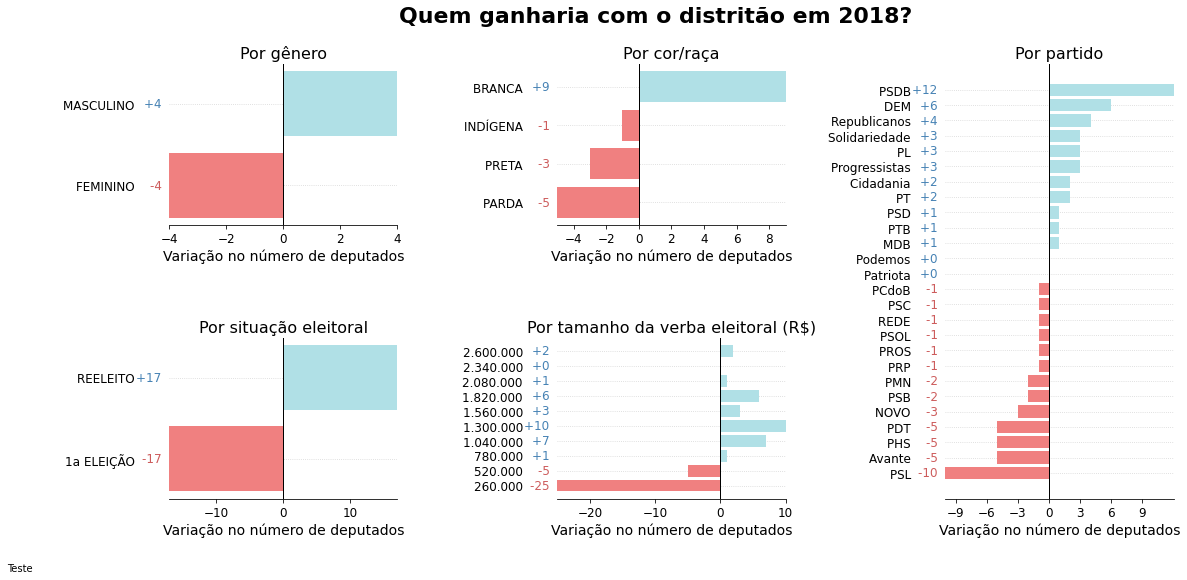

In [69]:
fig = pl.figure(figsize=(18,8))

fig.suptitle('Quem ganharia com o distritão em 2018?', fontsize=22, weight='bold')
fig.set_facecolor('white')

pl.subplot(2,3,1)
category = 'DS_GENERO'
balance_by_party = compute_change_balance(rejected, inserted, category)
plot_balance(balance_by_party)
pl.title('Por gênero', fontsize=16)

pl.subplot(2,3,2)
category = 'DS_COR_RACA'
balance_by_party = compute_change_balance(rejected, inserted, category)
plot_balance(balance_by_party)
pl.title('Por cor/raça', fontsize=16)
pl.xticks(range(-4,9, 2))

pl.subplot(2,3,4)
category = 'ELEITO_ANTERIOR'
balance_by_party = compute_change_balance(rejected, inserted, category)
plot_balance(balance_by_party)
pl.title('Por situação eleitoral', fontsize=16)

pl.subplot(2,3,5)
category = 'FAIXA_RECEITA'
balance_by_party = compute_change_balance(rejected, inserted, category)
cat_order = ['260.000', '520.000', '780.000', '1.040.000', '1.300.000', '1.560.000', '1.820.000', '2.080.000', '2.340.000', '2.600.000']
plot_balance(balance_by_party, cat_order=cat_order)
pl.title('Por tamanho da verba eleitoral (R$)', fontsize=16)

pl.subplot(1,3,3)
category = 'SG_PARTIDO'
balance_by_party = compute_change_balance(rejected, inserted, category)
plot_balance(balance_by_party)
pl.title('Por partido', fontsize=16)
pl.xticks(range(-9,10, 3))

pl.subplots_adjust(hspace=0.7, wspace=0.7)
#pl.savefig('../resultados/plots/ganhos_com_distritao_em_2018_geral.png', facecolor=fig.get_facecolor(), edgecolor='none')
fig.text(0,0, '')
pl.show()

#### Gráficos individuais

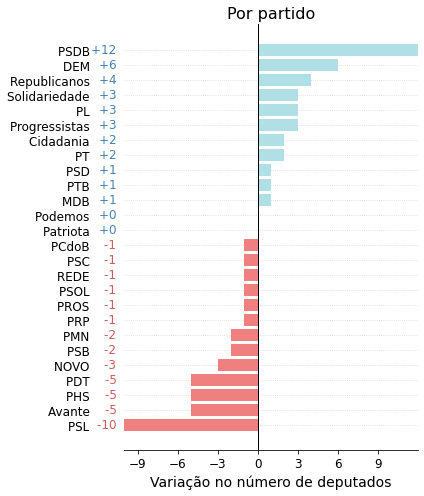

In [72]:
category = 'SG_PARTIDO'

balance_by_party = compute_change_balance(rejected, inserted, category)
fig = pl.figure(figsize=(6,7))
plot_balance(balance_by_party)
pl.title('Por partido', fontsize=16)
pl.xticks(range(-9,10, 3))
pl.tight_layout()
#pl.savefig('../resultados/plots/ganhos_com_distritao_em_2018_{}.png'.format(category))
pl.show()

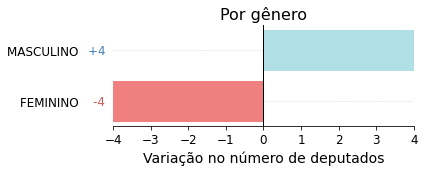

In [14]:
category = 'DS_GENERO'

balance_by_party = compute_change_balance(rejected, inserted, category)
fig = pl.figure(figsize=(6,2.5))
plot_balance(balance_by_party)
pl.title('Por gênero', fontsize=16)
pl.tight_layout()
#pl.savefig('../resultados/plots/ganhos_com_distritao_em_2018_{}.png'.format(category))
pl.show()

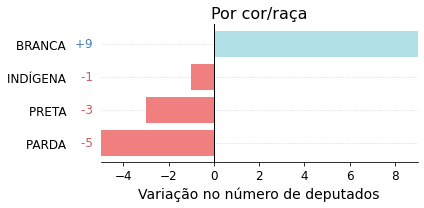

In [15]:
category = 'DS_COR_RACA'

balance_by_party = compute_change_balance(rejected, inserted, category)
fig = pl.figure(figsize=(6,3))
plot_balance(balance_by_party)
pl.title('Por cor/raça', fontsize=16)
pl.tight_layout()
#pl.savefig('../resultados/plots/ganhos_com_distritao_em_2018_{}.png'.format(category))
pl.show()

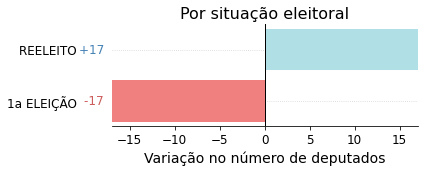

In [16]:
category = 'ELEITO_ANTERIOR'

balance_by_party = compute_change_balance(rejected, inserted, category)
fig = pl.figure(figsize=(6,2.5))
plot_balance(balance_by_party)
pl.title('Por situação eleitoral', fontsize=16)
pl.tight_layout()
#pl.savefig('../resultados/plots/ganhos_com_distritao_em_2018_{}.png'.format(category))
pl.show()

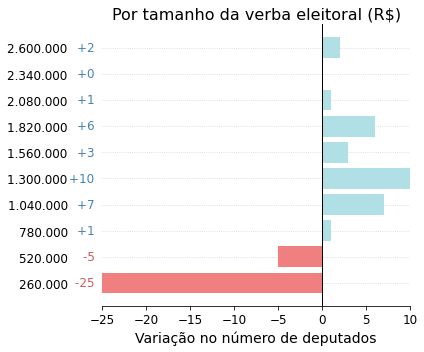

In [17]:
category = 'FAIXA_RECEITA'

balance_by_party = compute_change_balance(rejected, inserted, category)
fig = pl.figure(figsize=(6,5))
cat_order = ['260.000', '520.000', '780.000', '1.040.000', '1.300.000', '1.560.000', '1.820.000', '2.080.000', '2.340.000', '2.600.000']
plot_balance(balance_by_party, cat_order=cat_order)
pl.title('Por tamanho da verba eleitoral (R$)', fontsize=16)
pl.tight_layout()
#pl.savefig('../resultados/plots/ganhos_com_distritao_em_2018_{}.png'.format(category))
pl.show()